In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

[I 2025-03-22 09:52:14,659] A new study created in memory with name: no-name-98e404d6-4b23-4aaa-b225-de4127ebf2d4


X_train shape: (341490, 77)
X_test shape : (85996, 77)
Number of classes = 18

=== Start Optuna Search (Deep CNN Autoencoder) ===


  File "c:\Users\taejo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\taejo\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\taejo\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\taejo\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[I 2025-03-22 09:54:11,370] Trial 0 finished with value: 0.7353491815797544 and parameters: {'lr': 7.472928706642717e-05, 'weight_decay': 2.1192004798280632e-05, 'latent_dim': 96, 'c1': 192, 'c2': 160, 'dropout': 0.3, 'batch_size': 64, 'n_epochs': 10}. Best is trial 0 with value: 0.7353491815797544.
[I 


=== Best Trial ===
lr = 2.7094815375602647e-05
weight_decay = 0.00030436660203583154
latent_dim = 96
c1 = 128
c2 = 160
dropout = 0.2
batch_size = 64
n_epochs = 10
Best (1 - macroF1) = 0.7333
Best macroF1       = 0.2667


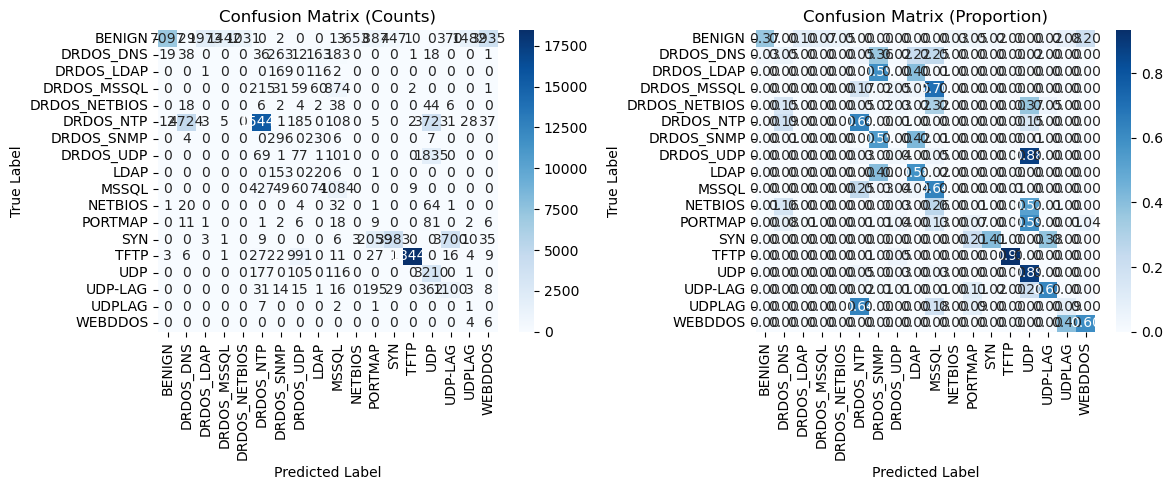

In [ ]:
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment  # Hungarian algorithm

######################################################################
# 1) Load Data & Preprocessing (User Provided Snippet) + Same numeric_cols
######################################################################
train_files = glob.glob("../data/*training.parquet")
test_files  = glob.glob("../data/*testing.parquet")

df_list = []
for f in train_files:
    temp = pd.read_parquet(f)
    df_list.append(temp)
for f in test_files:
    temp = pd.read_parquet(f)
    df_list.append(temp)

df_all = pd.concat(df_list, ignore_index=True)
df_all['Label'] = df_all['Label'].astype(str).str.upper().str.strip()

print(df_all.columns)

df_train, df_test = train_test_split(
    df_all, test_size=0.2, 
    stratify=df_all['Label'], random_state=42
)
df_train.dropna(inplace=True)
df_train.drop_duplicates(inplace=True)
df_test.dropna(inplace=True)
df_test.drop_duplicates(inplace=True)

numeric_cols = df_all.select_dtypes(include=[np.number]).columns
X_train_df = df_train[numeric_cols].copy()
X_test_df  = df_test[numeric_cols].copy()

le = LabelEncoder()
y_train_np = le.fit_transform(df_train['Label'].values)
y_test_np  = le.transform(df_test['Label'].values)
num_classes = len(le.classes_)

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_df)
X_test_np  = scaler.transform(X_test_df)

print("X_train shape:", X_train_np.shape)  # e.g., (N1, 78)
print("X_test shape :", X_test_np.shape)   # e.g., (N2, 78)
print(f"Number of classes = {num_classes}")

######################################################################
# 2) Complex CNN Autoencoder (Deeper + Dropout)
######################################################################
class DeepCNNAE(nn.Module):
    """
    - Encoder: Two Conv1d layers (stride=2) → reduces input by 1/4
        [Conv -> BatchNorm -> ReLU -> Dropout]  x N
    - Decoder: Reverse process with ConvTranspose layers, etc.
    - Reduces to latent_dim via a fully connected layer and then reconstructs.
    """
    def __init__(
        self,
        input_dim=78,
        latent_dim=32,
        c1=32,
        c2=64,
        dropout=0.0
    ):
        super().__init__()

        self.input_dim = input_dim
        self.c1 = c1
        self.c2 = c2

        # Encoder Part (Conv1d)
        # ConvBlock (stride=2)
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(1, c1, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(c1),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )
        # ConvBlock (stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(c1, c2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(c2),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )

        # First conv: out_len_1 = floor((input_dim + 2*1 - 3)/2 + 1)
        # Second conv: out_len_2 = floor((out_len_1 + 2*1 - 3)/2 + 1)
        def outlen_after_conv(in_len):
            return (in_len + 2*1 - 3) // 2 + 1

        out_1 = outlen_after_conv(input_dim)
        out_2 = outlen_after_conv(out_1)
        self.reduced_len = out_2
        self.flat_dim = c2 * out_2

        # Fully Connected Encoder
        self.fc_enc = nn.Sequential(
            nn.Linear(self.flat_dim, latent_dim),
            nn.ReLU()
        )

        # Decoder Part
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, self.flat_dim),
            nn.ReLU()
        )

        # ConvTranspose block 1 (stride=2)
        # out_len = (in_len - 1) * 2 - 2 + kernel + out_pad
        # kernel=3 or 4, pad=1
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose1d(c2, c1, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(c1),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        )

        # ConvTranspose block 2 (stride=2)
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose1d(c1, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        # x: (B, 1, input_dim)
        x = self.conv_block1(x)  # (B, c1, out_1)
        x = self.conv_block2(x)  # (B, c2, out_2)
        x = x.view(x.size(0), -1) # (B, c2*out_2)
        x = self.fc_enc(x)        # (B, latent_dim)
        return x

    def decode(self, z):
        out = self.fc_dec(z)     # (B, c2*out_2)
        out = out.view(out.size(0), self.c2, self.reduced_len)
        out = self.deconv_block1(out)  # (B, c1, ?)
        out = self.deconv_block2(out)  # (B, 1, ?) Ideally near input_dim
        # If needed, trim output to input_dim
        if out.size(2) > self.input_dim:
            out = out[:, :, :self.input_dim]
        return out

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

    def get_latent(self, x):
        return self.encode(x)

######################################################################
# 3) Training & Evaluation Utilities
######################################################################
def train_autoencoder(model, dataloader, optimizer, device, scheduler=None):
    model.train()
    criterion = nn.MSELoss()
    total_loss = 0.0
    for batch_x in dataloader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        recon = model(batch_x)
        loss = criterion(recon, batch_x)
        loss.backward()
        optimizer.step()
    if scheduler is not None:
        scheduler.step()

def evaluate_autoencoder(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    n_data = 0
    with torch.no_grad():
        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            recon = model(batch_x)
            loss = criterion(recon, batch_x)
            bs = batch_x.size(0)
            total_loss += loss.item() * bs
            n_data += bs
    return total_loss / max(1, n_data)

def get_latent_reps(model, X_full, device, batch_size=512):
    model.eval()
    dataset = torch.tensor(X_full, dtype=torch.float32).unsqueeze(1)  # (N, 1, input_dim)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    latents = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            z = model.get_latent(x)
            latents.append(z.cpu().numpy())
    return np.concatenate(latents, axis=0)

def cluster_to_class_map_kmeans(embeds, y_true, n_clusters):
    """
    Cluster using KMeans (n_init=10) then map clusters to classes using the Hungarian algorithm.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_ids = kmeans.fit_predict(embeds)

    cost_mat = np.zeros((n_clusters, n_clusters), dtype=int)
    for c in range(n_clusters):
        idx_c = np.where(cluster_ids == c)[0]
        true_labels_c = y_true[idx_c]
        for j in range(n_clusters):
            cost_mat[c, j] = np.sum(true_labels_c != j)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cluster_to_class = {}
    for r, c in zip(row_ind, col_ind):
        cluster_to_class[r] = c

    pred_labels = np.array([cluster_to_class[cid] for cid in cluster_ids])
    return pred_labels

def macro_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

######################################################################
# 4) Optuna Objective
######################################################################
def objective(trial):
    """
    Train a (unsupervised) Deep CNN Autoencoder -> get latent representations -> KMeans -> Hungarian mapping -> measure macro F1
    """
    global X_train_np, y_train_np, X_test_np, y_test_np, num_classes
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ------------------------
    # Hyperparameter Sampling
    # ------------------------
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    latent_dim = trial.suggest_int("latent_dim", 32, 128, step=32)
    c1 = trial.suggest_int("c1", 128, 256, step=64)
    c2 = trial.suggest_int("c2", 128, 256, step=32)
    dropout = trial.suggest_float("dropout", 0.2, 0.3, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [64])
    n_epochs = trial.suggest_int("n_epochs", 10, 20, step=10)

    input_dim = X_train_np.shape[1]

    # Create model
    model = DeepCNNAE(
        input_dim=input_dim,
        latent_dim=latent_dim,
        c1=c1,
        c2=c2,
        dropout=dropout
    ).to(device)

    # AdamW optimizer with learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # (optional) scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
    scheduler = None  # Use if desired

    # ------------------------
    # DataLoader
    # ------------------------
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1)
    train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)

    # ------------------------
    # Training Loop
    # ------------------------
    for epoch in range(n_epochs):
        train_autoencoder(model, train_loader, optimizer, device, scheduler=scheduler)
        # trial.report() can be used here...
        if trial.should_prune():
            raise optuna.TrialPruned()

    # ------------------------
    # Evaluate on Test Set
    # ------------------------
    latents_test = get_latent_reps(model, X_test_np, device, batch_size)
    pred_test = cluster_to_class_map_kmeans(latents_test, y_test_np, num_classes)
    mf1 = macro_f1_score(y_test_np, pred_test)

    # Optuna minimizes the objective -> return 1 - F1
    return 1.0 - mf1


def plot_confusion_matrices(y_true, y_pred, class_labels=None, figsize=(12, 5), cmap='Blues'):
    """
    - y_true, y_pred: Labels in integer format
    - class_labels: List of class names corresponding to label indices
    - figsize: Size of the overall figure
    - cmap: Heatmap colormap
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # (1) Count-based Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d',
                cmap=cmap, ax=axes[0],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    axes[0].set_title('Confusion Matrix (Counts)')

    # (2) Proportion-based Confusion Matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2f',
                cmap=cmap, ax=axes[1],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title('Confusion Matrix (Proportion)')

    plt.tight_layout()
    plt.show()


######################################################################
# 5) Main
######################################################################
if __name__ == "__main__":
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n=== Start Optuna Search (Deep CNN Autoencoder) ===")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5, timeout=3600)

    best_trial = study.best_trial
    best_val = best_trial.value
    best_f1 = 1.0 - best_val

    print("\n=== Best Trial ===")
    for k, v in best_trial.params.items():
        print(f"{k} = {v}")
    print(f"Best (1 - macroF1) = {best_val:.4f}")
    print(f"Best macroF1       = {best_f1:.4f}")

    best_params = best_trial.params
    input_dim = X_train_np.shape[1]

    # Build the best model
    best_model = DeepCNNAE(
        input_dim=input_dim,
        latent_dim=best_params["latent_dim"],
        c1=best_params["c1"],
        c2=best_params["c2"],
        dropout=best_params["dropout"]
    ).to(device)

    optimizer = optim.AdamW(
        best_model.parameters(),
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"]
    )
    scheduler = None

    # Dataloader
    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(1)
    train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=best_params["batch_size"], shuffle=True)

    # Train the model
    for epoch in range(best_params["n_epochs"]):
        train_autoencoder(best_model, train_loader, optimizer, device, scheduler=scheduler)

    # Get Test Latent Representations
    latents_test = get_latent_reps(best_model, X_test_np, device, best_params["batch_size"])
    # Predict (KMeans + Hungarian mapping)
    pred_test = cluster_to_class_map_kmeans(latents_test, y_test_np, num_classes)

    # ------------------------
    # (Additional) Visualize Confusion Matrix
    # ------------------------
    # Get class names corresponding to label indices
    class_labels = list(le.classes_)
    plot_confusion_matrices(y_test_np, pred_test, class_labels=class_labels, figsize=(30, 15))
